# Lab 5 - Time series prediction with LSTM (IOT Data)

This lab corresponds to Module 5 of the "Deep Learning Explained" course.

In this lab we want to build a model using some real world internet-of-things ([IOT](https://en.wikipedia.org/wiki/Internet_of_things)) data. As an example we want to predict the daily output of a solar panel base on the initial readings of the day. 

[Solar power forecasting](https://en.wikipedia.org/wiki/Solar_power_forecasting) is a challenging and important problem. The solar energy generation forecasting problem is closely linked to the problem of weather variables forecasting. Indeed, this problem is usually split into two parts, on one hand focusing on the forecasting of solar PV (solar panel system) or any other meteorological variable and on the other hand estimating the amount of energy that a concrete power plant will produce with the estimated meteorological resource. In general, the way to deal with this difficult problem is usually related to the spatial and temporal scales we are interested in. This lab focusses on a simplified forecasting model using previously generated data from solar panel to predict the future. 

**Goal**

Using historic daily production of a solar panel, we want to predict the total power production of the solar panel array for a future day. We will be using an LSTM based time series prediction model to predict the daily output of a solar panel based on the initial readings of a the day. 

![rooftop-solar](https://www.cntk.ai/jup/rooftop-solar-power.jpg)

We train the model with historical data of the solar panel. In our example we want to predict the total power production of the solar panel array for the day starting with the initial readings of the day. We start predicting after the first 2 readings and adjust the prediction with each new reading.

We will use a recurrent model with the LSTM cell. This lab has the following sub-sections:
- Setup
- Data generation
- LSTM network modeling
- Training, test and prediction workflow

For more details on how LSTMs work, view the Module 5 videos or see [this excellent post](http://colah.github.io/posts/2015-08-Understanding-LSTMs).

# Setup

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import os
import pandas as pd
import random
import time

import cntk as C

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

%matplotlib inline

In [2]:
# to make things reproduceable, seed random
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

In the block below, we check if we are running this notebook in the CNTK internal test machines by looking for environment variables defined there. We then select the right target device (GPU vs CPU) to test this notebook. In other cases, we use CNTK's default policy to use the best available device (GPU, if available, else CPU).

In [3]:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

In [4]:
# Test for CNTK version
if not C.__version__ == "2.0":
    raise Exception("this notebook was designed to work with 2.0. Current Version: " + C.__version__) 

Exception: this notebook was designed to work with 2.0. Current Version: 2.5.1

There are two training modes that we can choose from for this lab:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

For *Fast mode* we train the model for 100 epochs and results have low accuracy but is good enough for development. The model yields good accuracy after 1000-2000 epochs.

In [5]:
isFast = True

# we need around 2000 epochs to see good accuracy. For testing 100 epochs will do.
EPOCHS = 200 if isFast else 2000

# Data generation

Our solar panel emits two measures at 30 min interval:
- `solar.current` is the current production in Watt
- `solar.total` is the total produced for the day so far in Watt/hour

Our prediction approach involves starting with the first 2 initial readings of the day. Based on these readings we start predicting and adjust the prediction with each new reading. The training data we are going to use comes as a CSV file and has the following format:

>```
time,solar.current,solar.total
7am,6.3,1.7
7:30am,44.3,11.4
...
>```

Our training dataset contains 3 years of captured data and can be found [here](https://guschmueds.blob.core.windows.net/datasets/solar.csv). 
The dataset is not pre-processed: it is raw data and contains smaller gaps and errors (like a panel failed to report).

## Pre-processing
Most of the code in this example is related to data preparation. Thankfully the pandas library make this easy.

Below, we define a `generate_solar_data()` function that performs the following tasks:
- read raw data into a pandas dataframe
- normalize the data
- group the data by day
- append the columns "solar.current.max" and "solar.total.max"
- generate the sequences for each day

** Sequence Generation ** The measurements for a day are grouped into a set of sequences, corresponding to each measurement for the day.  Each measurement sequence will contain all of the raw measurements (solar.current, solar.total) seen for the current day, up until and including the current measurement.  

Here is an example of some sequehnces for a day:
```
1.7,11.4 -> 10300
1.7,11.4,67.5 -> 10300
1.7,11.4,67.5,250.5 ... -> 10300
1.7,11.4,67.5,250.5,573.5 -> 10300
```

All sequences for all days are flattened into a single list of sequences. The day and timestamp information have been removed; only the sequences matter.

**Note** if we have less than 8 datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than 14 data points in a day we truncate the readings.

## Training / Testing / Validation data preparation
We start by reading the CSV file. The raw data is sorted by time.  Normally, we would randomize the data before splitting into training, validation and test datasets, but this would make it impractical to visualize results. 

Hence, we split the dataset in the following manner: pick the following (in sequence order): 8 values for training, 1 for validation and 1 for test until there is no more data. This will spread training, validation and test datasets across the full timeline while preserving time order.


In [6]:
def generate_solar_data(input_url, time_steps, normalize=1, val_size=0.1, test_size=0.1):
    """
    generate sequences to feed to rnn based on data frame with solar panel data
    the csv has the format: time ,solar.current, solar.total
     (solar.current is the current output in Watt, solar.total is the total production
      for the day so far in Watt hours)
    """
    # try to find the data file local. If it doesn't exists download it.
    cache_path = os.path.join("data", "iot")
    cache_file = os.path.join(cache_path, "solar.csv")
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    if not os.path.exists(cache_file):
        urlretrieve(input_url, cache_file)
        print("downloaded data successfully from ", input_url)
    else:
        print("using cache for ", input_url)
    
    df = pd.read_csv(cache_file, index_col="time", parse_dates=['time'], dtype=np.float32)
    
    df["date"] = df.index.date
    
    # normalize data
    df['solar.current'] /= normalize
    df['solar.total'] /= normalize
    
    # group by day, find the max for a day and add a new column .max
    grouped = df.groupby(df.index.date).max()
    grouped.columns = ["solar.current.max", "solar.total.max", "date"]

    # merge continuous readings and daily max values into a single frame
    df_merged = pd.merge(df, grouped, right_index=True, on="date")
    df_merged = df_merged[["solar.current", "solar.total",
                           "solar.current.max", "solar.total.max"]]
    # we group by day so we can process a day at a time.
    grouped = df_merged.groupby(df_merged.index.date)
    per_day = []
    for _, group in grouped:
        per_day.append(group)

    # split the dataset into train, validatation and test sets on day boundaries
    val_size = int(len(per_day) * val_size)
    test_size = int(len(per_day) * test_size)
    next_val = 0
    next_test = 0

    result_x = {"train": [], "val": [], "test": []}
    result_y = {"train": [], "val": [], "test": []}    

    # generate sequences a day at a time
    for i, day in enumerate(per_day):
        # if we have less than 8 datapoints for a day we skip over the
        # day assuming something is missing in the raw data
        total = day["solar.total"].values
        if len(total) < 8:
            continue
        if i >= next_val:
            current_set = "val"
            next_val = i + int(len(per_day) / val_size)
        elif i >= next_test:
            current_set = "test"
            next_test = i + int(len(per_day) / test_size)
        else:
            current_set = "train"
        max_total_for_day = np.array(day["solar.total.max"].values[0])
        for j in range(2, len(total)):
            result_x[current_set].append(total[0:j])
            result_y[current_set].append([max_total_for_day])
            if j >= time_steps:
                break
    # make result_y a numpy array
    for ds in ["train", "val", "test"]:
        result_y[ds] = np.array(result_y[ds])
    return result_x, result_y

## Data caching
For routine testing we would like to cache the data locally when available. If it is not available from the cache locations we shall download.

In [7]:
# there are 14 lstm cells, 1 for each possible reading we get per day
TIMESTEPS = 14

# 20000 is the maximum total output in our dataset. We normalize all values with 
# this so our inputs are between 0.0 and 1.0 range.
NORMALIZE = 20000

X, Y = generate_solar_data("https://www.cntk.ai/jup/dat/solar.csv", 
                           TIMESTEPS, normalize=NORMALIZE)

using cache for  https://www.cntk.ai/jup/dat/solar.csv


### Utility for data fetching

`next_batch()` yields the next batch for training. We use variable size sequences supported by CNTK and batches are a list of numpy arrays where the numpy arrays have variable length. 

A standard practice is to shuffle batches with each epoch. We don't do this here because we want to be able to graph the data that is easily interpretable.

In [8]:
# process batches of 10 days
BATCH_SIZE = TIMESTEPS * 10

def next_batch(x, y, ds):
    """get the next batch for training"""

    def as_batch(data, start, count):
        return data[start:start + count]

    for i in range(0, len(x[ds]), BATCH_SIZE):
        yield as_batch(X[ds], i, BATCH_SIZE), as_batch(Y[ds], i, BATCH_SIZE)

### Understand the data format
You can now see the sequence we are going to feed to the LSTM. Note if we have less than 8 datapoints for a day we skip over the day assuming something is missing in the raw data. If we get more than 14 data points in a day we truncate the readings.

In [9]:
X['train'][0:3]

[array([0.       , 0.0006985], dtype=float32),
 array([0.       , 0.0006985, 0.0033175], dtype=float32),
 array([0.       , 0.0006985, 0.0033175, 0.010375 ], dtype=float32)]

In [10]:
Y['train'][0:3]

array([[0.239],
       [0.239],
       [0.239]], dtype=float32)

In [11]:
len(X['train']), len(Y['train'])

(10747, 10747)

In [12]:
len(X['test']), len(Y['test'])

(1365, 1365)

## LSTM network setup

LSTM will automatically adapt to the maximum sequence length of our data; we **do not need to specify this maximum length** as part of our model and we **do not need to pad** our variable length sequences in any way.

We model our network with H_DIMS = 14 LSTM cells, which we have found (by trying other values) produces good prediction results for our problem.  


The output of the neural network is the total output for the day and each sequence for a given day has the same total output.

For example:
```
1.7,11.4 -> 10300
1.7,11.4,67.5 -> 10300
1.7,11.4,67.5,250.5 ... -> 10300
1.7,11.4,67.5,250.5,573.5 -> 10300
```

The outputs from the LSTMs are feed into a dense layer and we randomly dropout 20% of the values to not overfit the model to the training set. The output of the dense layer becomes the prediction our model generates.

Our LSTM model has the following design:
![lstm](https://guschmueds.blob.core.windows.net/datasets/2.png)

The network model is an exact translation of the network diagram above.

In [13]:
#Define the size of the internal state
H_DIMS = 14              
def create_model(x):
    """Create the model for time series prediction"""
    with C.layers.default_options(initial_state = 0.1):
        m = C.layers.Recurrence(C.layers.RNNStep(H_DIMS))(x)
        m = C.sequence.last(m)
        m = C.layers.Dropout(0.2)(m)
        m = C.layers.Dense(1)(m)
        return m

# Training
Before we can start training we need to bind our input variables for the model and define which optimizer we want to use. For this example we choose the `adam` optimizer. We choose `squared_error` as our loss function.

In [14]:
# input sequences
x = C.sequence.input_variable(1)

# create the model
z = create_model(x)

# expected output (label), also the dynamic axes of the model output
# is specified as the model of the label input
l = C.input_variable(1, dynamic_axes=z.dynamic_axes, name="y")

# the learning rate
learning_rate = 0.005
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)

# loss and error function
loss = C.squared_error(z, l)
error = C.squared_error(z, l)

# use adam optimizer
momentum_time_constant = C.momentum_as_time_constant_schedule(BATCH_SIZE / -math.log(0.9)) 
learner = C.fsadagrad(z.parameters, 
                      lr = lr_schedule, 
                      momentum = momentum_time_constant)

trainer = C.Trainer(z, (loss, error), [learner])

Time to start training.

In [15]:
# training
loss_summary = []

start = time.time()
for epoch in range(0, EPOCHS):
    for x_batch, l_batch in next_batch(X, Y, "train"):
        trainer.train_minibatch({x: x_batch, l: l_batch})
        
    if epoch % (EPOCHS / 10) == 0:
        training_loss = trainer.previous_minibatch_loss_average
        loss_summary.append(training_loss)
        print("epoch: {}, loss: {:.4f}".format(epoch, training_loss))

print("Training took {:.1f} sec".format(time.time() - start))

epoch: 0, loss: 0.6545
epoch: 20, loss: 0.0938
epoch: 40, loss: 0.0765
epoch: 60, loss: 0.0688
epoch: 80, loss: 0.0588
epoch: 100, loss: 0.0674
epoch: 120, loss: 0.0570
epoch: 140, loss: 0.0601
epoch: 160, loss: 0.0573
epoch: 180, loss: 0.0587
Training took 189.7 sec


A look how the loss function shows how the model is converging:

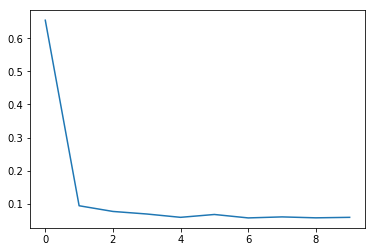

In [16]:
plt.plot(loss_summary, label='training loss');

Let us evaluate our performance for the training, validation, and test datasets. We use mean squared error as our metric which might be a little simplistic. A method that would define a ratio of how many predictions have been inside a given tolerance would make a better measure.

** Suggested Exploration: ** Try out absolute error (`C.abs(z-l)`) instead of a squared error. 

In [17]:
# evaluate the specified X and Y data on our model
def get_error(X,Y,labeltxt):
    result = 0.0
    numbatches = 0
    for x1, y1 in next_batch(X, Y, labeltxt):
        eval_error = trainer.test_minibatch({x : x1, l : y1})
        result += eval_error
        numbatches += 1

    return float(result)/numbatches

In [18]:
# Print the training and validation errors
for labeltxt in ["train", "val"]:
    print("Error for {}: {:.8f}".format(labeltxt, get_error(X, Y, labeltxt)))

Error for train: 0.03214735
Error for val: 0.02884785


In [19]:
# Print the test error
labeltxt = "test"
print("Error for {}: {:.8f}".format(labeltxt, get_error(X, Y, labeltxt)))

Error for test: 0.03290150


# Visualize the prediction

Our model has been trained well, given that the training, validation and test errors are in the same ballpark. To better understand our predictions, let's visualize the results.  We will take our newly created model, make predictions and plot them against the actual readings.

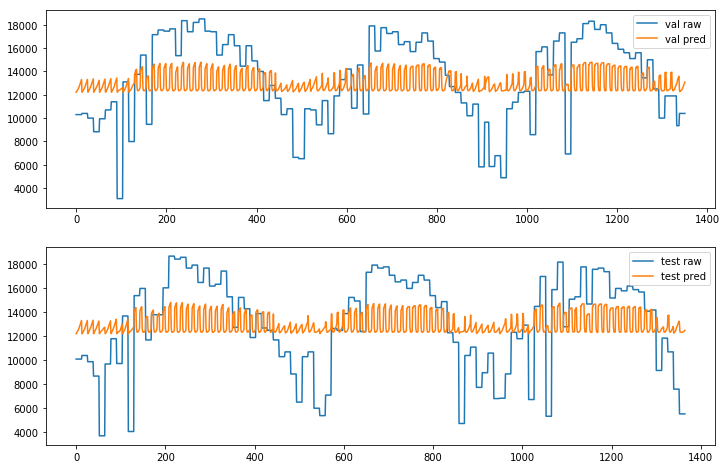

In [20]:
# predict
f, a = plt.subplots(2, 1, figsize=(12, 8))
for j, ds in enumerate(["val", "test"]):
    results = []
    for x_batch, _ in next_batch(X, Y, ds):
        pred = z.eval({x: x_batch})
        results.extend(pred[:, 0])
    # because we normalized the input data we need to multiply the prediction
    # with SCALER to get the real values.
    a[j].plot((Y[ds] * NORMALIZE).flatten(), label=ds + ' raw');
    a[j].plot(np.array(results) * NORMALIZE, label=ds + ' pred');
    a[j].legend();

If we let the model train for 2000 epochs the predictions are close to the actual data and follow the right pattern.

** Suggested Exploration **

So what we do with this model? A practical application would be to generate alerts if the actual output is not in line with the prediction, for example if one of the panels is failing. The solar array that goes with our dataset has 16 panels. If we'd want to detect failure without generating false alerts, the accuracy of our prediction would need to be at least 1 - 1/16, around 94%. Our model is close to this but would most likely generate occasional false alerts.

- Improve the model by training for more epochs.
- Further preprocess the training set to smooth-out missing values
- Try out more complex networks.

In our experience with time series data, one can achieve significant accuracy improvement using higher resolution training data, for example, reading a data point every 5 minutes instead of every 30 minutes.

We hope this tutorial gets you started on time series prediction with neural networks.